In [14]:
from __future__ import print_function
# from IPython.display import Math, HTML
import keras
import struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop, Adam, SGD

# Dataset Exploration

Shape of MNIST train images: (10000, 28, 28)
Shape of MNIST test images: (4000, 28, 28)


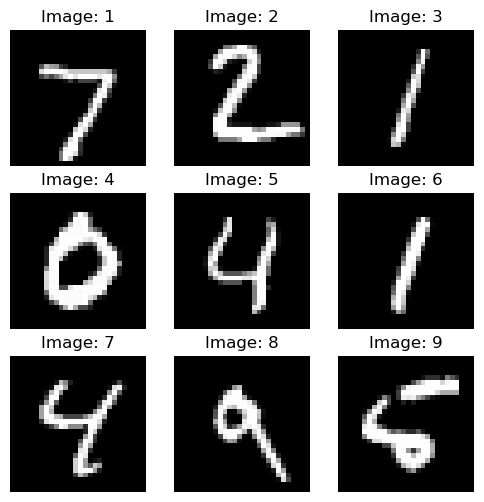

In [22]:
# make a function to get the MNIST data from a file and return it as a numpy array
def read_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        # Read magic number, number of images, rows, and columns
        magic_number, num_images, rows, cols = struct.unpack('>IIII', f.read(16))

        # Read image data
        image_size = rows * cols
        images = np.frombuffer(f.read(image_size * num_images), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)

    return images

# Provide the path to your MNIST dataset file
file_path = './datasets/10k_images.dat'
file_path2 = './datasets/4kfrom60k.dat'

# Read MNIST images from the fileread_mnist_images(file_path)
train_data = read_mnist_images(file_path)
test_data = read_mnist_images(file_path2)
# Print the shape of the data
print(f'Shape of MNIST train images: {train_data.shape}')
print(f'Shape of MNIST test images: {test_data.shape}')

# Display the first 9 images in training data
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i, axis in enumerate(ax.flat):
    axis.imshow(train_data[i], cmap='gray')
    axis.axis('off')
    axis.set(title = f'Image: {i+1}')
plt.show()



# Data Pre-processing

In [23]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
# check the shape of the data
print(f'Shape of MNIST images: {train_data.shape}')

# convert the data type to float32
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# check the type of the data
print(f'Type of MNIST train images: {train_data.dtype}')
print(f'Type of MNIST test images: {test_data.dtype}')


# normalize the data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

# check the range of the data
print(f'Range of MNIST test images: {train_data.min()} to {train_data.max()}')
print(f'Range of MNIST train images: {test_data.min()} to {test_data.max()}')

# parition the data into training and validation sets
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                                train_data,
                                                                test_size=0.2)

# print the shape of training data and validation data
print(f'Shape of training data: {train_X.shape}')
print(f'Shape of validation data: {valid_X.shape}')

print(f'Shape of training labels: {train_ground.shape}')
print(f'Shape of validation labels: {valid_ground.shape}')

Shape of MNIST images: (10000, 28, 28, 1)
Type of MNIST train images: float32
Type of MNIST test images: float32
Range of MNIST test images: 0.0 to 1.0
Range of MNIST train images: 0.0 to 1.0
Shape of training data: (8000, 28, 28, 1)
Shape of validation data: (2000, 28, 28, 1)
Shape of training labels: (8000, 28, 28, 1)
Shape of validation labels: (2000, 28, 28, 1)


# The Convolutional Autoencoder

In [24]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))

In [31]:
def encoder(input_img):
    # Encoder layers
    conv1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (7, 7), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (7, 7), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)

    # Latent dimension (change the size as needed)
    latent_dim = 10
    bottleneck = Conv2D(latent_dim, (7, 7), activation='relu', padding='same')(conv3)
    bottleneck = BatchNormalization()(bottleneck)

    return bottleneck

def decoder(bottleneck):
    # Decoder layers
    conv4 = Conv2D(128, (7, 7), activation='relu', padding='same')(bottleneck)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (7, 7), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2, 2))(conv5)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(up2)

    return decoded

# Input layer
input_img = Input(shape=(28, 28, 1))

# Create the encoder and decoder models
encoder_model = Model(input_img, encoder(input_img))
autoencoder = Model(input_img, decoder(encoder(input_img)))

# Compile the autoencoder model
encoder_model.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))

# Print model summaries
encoder_model.summary()
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization_22 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 64)        100416    
                                                                 
 batch_normalization_23 (Bat  (None, 14, 14, 64)       256 

# Train the model

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/10
63/63 [==============================] - 115s 2s/step - loss: 0.1251 - val_loss: 0.1237
Epoch 2/10
63/63 [==============================] - 105s 2s/step - loss: 0.0875 - val_loss: 0.0848
Epoch 3/10
63/63 [==============================] - 125s 2s/step - loss: 0.0537 - val_loss: 0.0645
Epoch 4/10
63/63 [==============================] - 126s 2s/step - loss: 0.0333 - val_loss: 0.0500
Epoch 5/10
63/63 [==============================] - 126s 2s/step - loss: 0.0247 - val_loss: 0.0327
Epoch 6/10
63/63 [==============================] - 137s 2s/step - loss: 0.0196 - val_loss: 0.0521
Epoch 7/10
63/63 [==============================] - 143s 2s/step - loss: 0.0160 - val_loss: 0.0205
Epoch 8/10
63/63 [==============================] - 148s 2s/step - loss: 0.0132 - val_loss: 0.0273
Epoch 9/10
63/63 [==============================] - 134s 2s/step - loss: 0.0115 - val_loss: 0.0186
Epoch 10/10
63/63 [==============================] - 136s 2s/step - loss: 0.0104 - val_loss: 0.0165


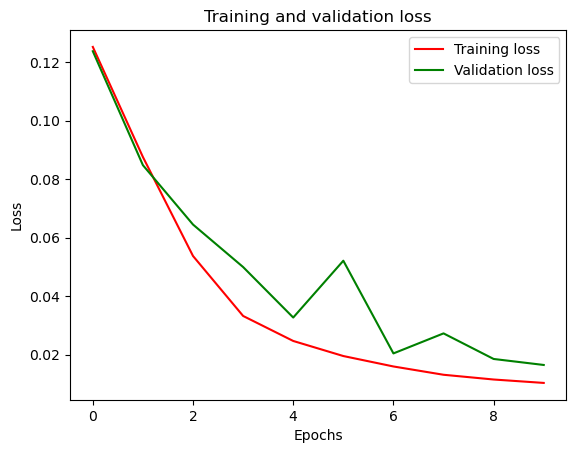

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, '-r', label='Training loss')
plt.plot(epochs, val_loss, '-g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the Model

125/125 [==============================] - 16s 132ms/step


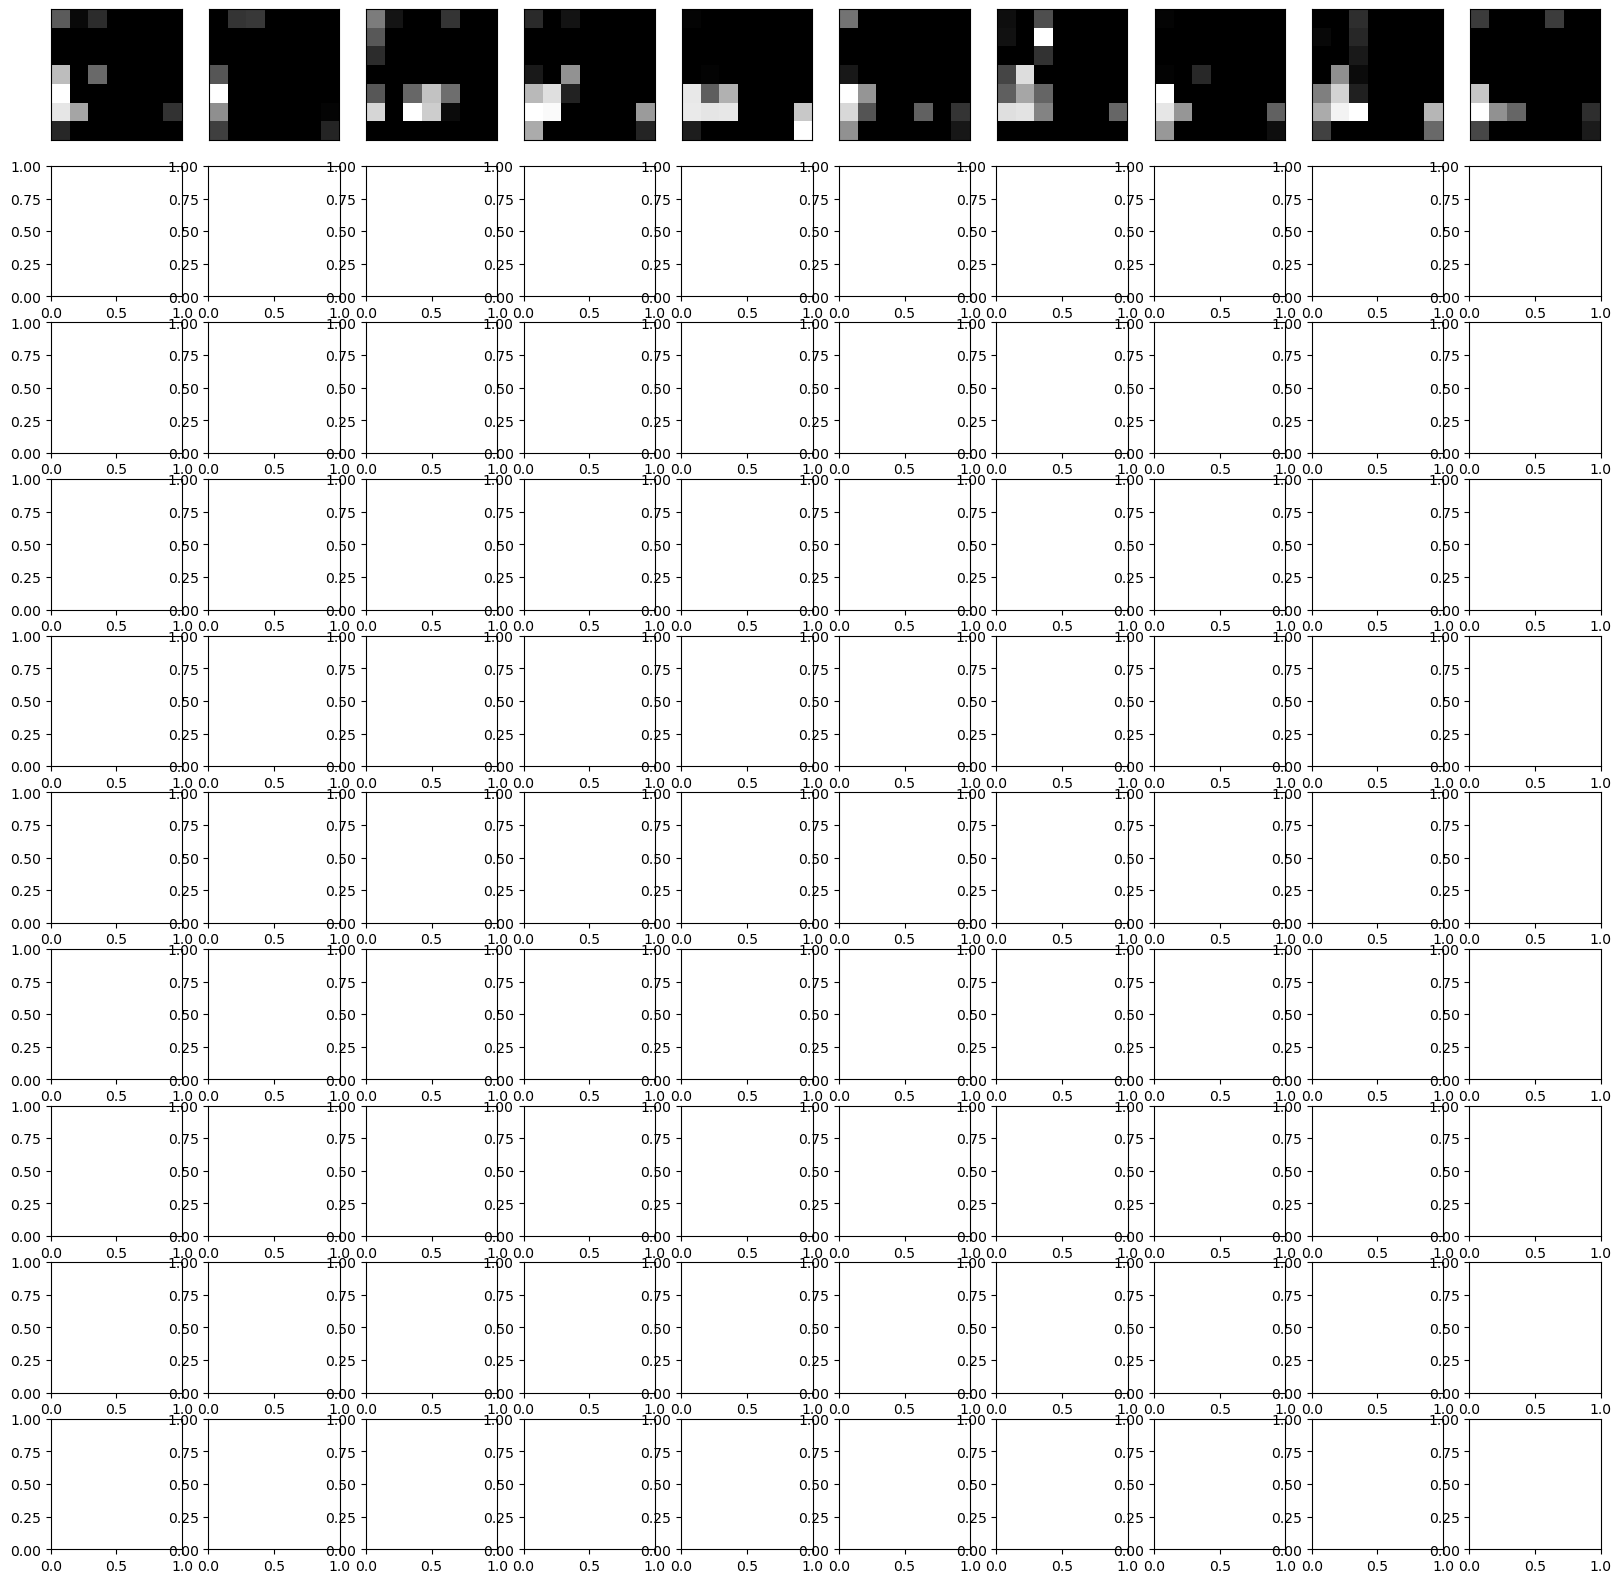

In [35]:
# # Predict the autoencoder output from test images
# pred = autoencoder.predict(test_data)

# # Plot the original test images and their reconstructions
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
# for images, row in zip([test_data, pred], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(img.reshape((28, 28)), cmap='gray')
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
# plt.show()

# Predict the encoder output from test images
encoded_data = encoder_model.predict(test_data)

# Display the encoded representations
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
for i in range(1):  # Iterate over each encoded dimension
    for j in range(10):  # Iterate over 10 images
        # Select the i-th channel from the j-th image
        channel_img = encoded_data[j, :, :, i]

        # Plot the 7x7 image
        axes[i, j].imshow(channel_img, cmap='gray')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
plt.show()

# save the model
autoencoder.save('autoencoder.h5')
encoder_model.save('encoder.h5')
